# Visualize the Keywords using LDA Algorithm

In [6]:
import pandas as pd
import gensim
import jieba

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

from wordcloud import WordCloud

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

# Prepare the Dataset

In [7]:
def read_json_dataset(filename):
    """
    Read JSON dataset and return the job requirements
    
    Returns:
        job requirements
    """
    dataset = pd.read_json(filename)
    
    return dataset['requirement'] + ' ' + dataset['requirement_others']


def tokenizer(doc):
    return jieba.cut(doc, cut_all=False)


def get_chinese_stopwords():
    """
    Get Chinese stopwords
    """
    with open('./中文停用词表.txt') as f:
        lines = f.readlines()
        stopwords_chinese = [w.strip() for w in lines]
        
    return stopwords_chinese

    
def preprocess(raw_docs):
    """
    Normalize, tokenize, remove stopwords, use custom dictionary
    
    Args:
        raw_docs (list(str)):
        
    Returns:
        docs (list(list(str))): list of tokens in a document
    """
    
    docs = []
    
    # define customized stopwords
    stopwords_custom = ['•', '與', '★', '●', '（', '’', '－', '✦', '◆', '◼', '✪', 
                        '※', '⁺', '', '', '·', '‧', '・', '）', '○', '】', '【', '✓', '']
    
    stopwords_chinese = get_chinese_stopwords()
    
    for d in tqdm(raw_docs):
        # Normalize English words
        d = d.lower()
        
        tokens = []
        
        for t in tokenizer(d):  
            # Strip English punctuations
            t = gensim.parsing.preprocessing.strip_punctuation(t)
            
            # Remove numbers
            t = gensim.parsing.preprocessing.strip_numeric(t)
            
            t = t.strip()
            
            if t is '':
                continue
                
            if t not in stopwords_custom:
                if t not in stopwords_chinese:
                    if t not in gensim.parsing.preprocessing.STOPWORDS:
                        tokens.append(t)
                    
        docs.append(tokens)
        
    return docs


def get_dictionary(docs):
    return gensim.corpora.Dictionary(docs)


def get_corpus_bow(docs, dictionary):
    """
    Get corpus with format of BOW
    
    Args:
        docs (list(list(str))): list of list of string token
        dictionary (gensim.corpora.Dictionary): dictionary
        
    Returns:
        bows (list(list(tuple(token_id, num_tokens))))
    """
    bows = [dictionary.doc2bow(d) for d in docs]
    
    return bows


def get_corpus_tfidf(bows):
    """
    Get corpus based on TF-IDF and TF-IDF model
    
    Args:
        bows (list(list(tuple(token_id, num_tokens)))): BOW
        
    Returns:
        corpus_tfidf (gensim.interfaces.TransformedCorpus): corpus class
        tfidf_model: 
    """
    tfidf_model = gensim.models.TfidfModel(bows)
    corpus_tfidf = tfidf_model[bows]
    
    return corpus_tfidf, tfidf_model


In [13]:
filename_dataset = '../crawler/employment_website_104/dataset/jobs_104.json'
no_below = 6
no_above = 0.1
num_topics = 4
passes = 20
iterations = 400

In [17]:
raw_docs = read_json_dataset(filename_dataset)

# Normalize, tokenize, remove stopwords, use custom dictionary
docs = preprocess(raw_docs)

# Create dictionary
dictionary = get_dictionary(docs)
print('Size of dictionary before filtering out extreme words: {}'.format(len(dictionary)))

# Remove common/rare words
dictionary.filter_extremes(no_below=no_below, no_above=no_above)
print('Size of dictionary after filtering out extreme words: {}'.format(len(dictionary)))

# generate BOW corpus
corpus_bow = get_corpus_bow(docs, dictionary)

# generate TF-IDF corpus using BOW
corpus_tfidf, tfidf_model = get_corpus_tfidf(corpus_bow)

100%|██████████| 996/996 [00:06<00:00, 151.04it/s]


Size of dictionary before filtering out extreme words: 10764
Size of dictionary after filtering out extreme words: 2444


In [18]:
type(corpus_tfidf)

gensim.interfaces.TransformedCorpus

# Main Training Program

In [15]:
# train BOW model
lda_model_bow = gensim.models.LdaModel(corpus_bow,
                                       num_topics=num_topics,
                                       id2word=dictionary,
                                       passes=passes,
                                      iterations=iterations,
                                      alpha='auto', eta='auto')


In [19]:
# train TF-IDF model
lda_model_tfidf = gensim.models.LdaModel(corpus_tfidf,
                                        num_topics=num_topics,
                                        id2word=dictionary,
                                        passes=passes,
                                        iterations=iterations,
                                      alpha='auto', eta='auto')

# Save Models

In [20]:
filename_prefix_bow = './models/model_bow.lda'
filename_preifx_tfidf = './models/model_tfidf.lda'

In [21]:

lda_model_bow.save(filename_prefix_bow)
lda_model_tfidf.save(filename_preifx_tfidf)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Restore Models

In [22]:
lda_model_bow = gensim.models.LdaModel.load(filename_prefix_bow)
lda_model_tfidf = gensim.models.LdaModel.load(filename_preifx_tfidf)

# Display Key Factors of Each Topic

In [36]:
def get_keywords_df(model):
    init_values = [['']*num_topics]*10
    keywords_df = pd.DataFrame(init_values, columns=['topic{}'.format(i) for i in range(num_topics)])


    for i_topic, topic in model.show_topics(-1, formatted=False):
        for i_word, (word, weight) in enumerate(topic):
            keywords_df.iloc[i_word][i_topic] = word
            
    return keywords_df
    
    
def plot_word_cloud(keywords_df, font_path='./fonts/NotoSerifCJKtc-Black.otf'):
    num_topics = len(keywords_df.iloc[0])
    
    fig, axs = plt.subplots(num_topics)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i_topic in range(num_topics):
        text = ' '.join(w for w in keywords_df.iloc[:, i_topic])
        print('Topic {}: {}'.format(i_topic, text))
        wordCloud = WordCloud(background_color='white', font_path=font_path).generate(text)

        axs[i_topic].imshow(wordCloud)
        axs[i_topic].axis('off')
        axs[i_topic].set_title('Topic {}'.format(i_topic), size=20)

Topic 0: image equipment algorithm control test project customer manufacturing d production
Topic 1: training cloud services models analytics build teams service company sales
Topic 2: 舖 經營 主任 培訓 環境 培育 分店 門市 獎金 表現
Topic 3: 數據 軟體 深度 產品 專案 影像 研究 客戶 模型 工程


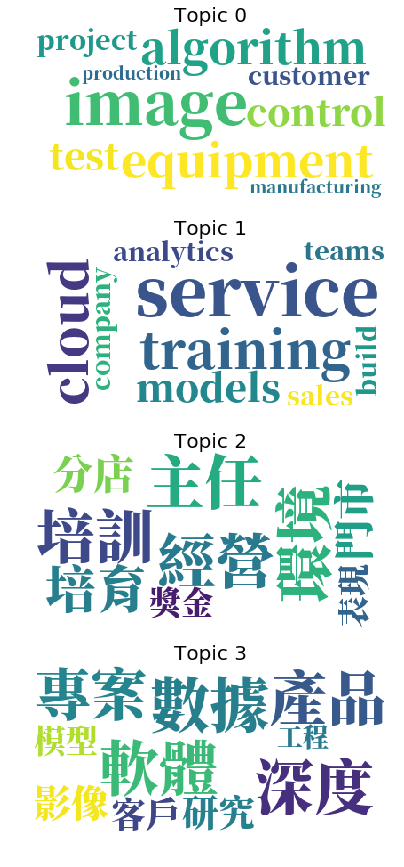

In [37]:
keywords_bow_df = get_keywords_df(lda_model_bow)
plot_word_cloud(keywords_bow_df)

Topic 0: 獎金 環境 門市 完善 制度 教育 福利 年度 請 次
Topic 1: 舖 經營 主任 培訓 分店 培育 區 表現 約 發展
Topic 2: 影像 數據 軟體 深度 模型 研究 佳 統計 經驗者 產品
Topic 3: training image algorithm project cloud test customer models service techniques


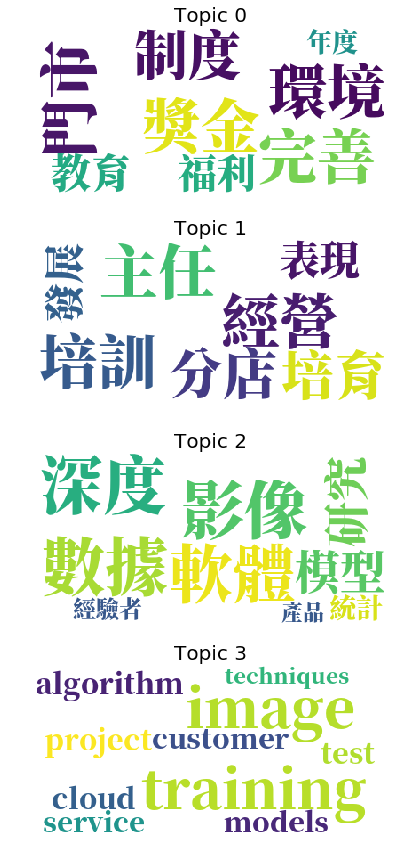

In [38]:
keywords_df = get_keywords_df(lda_model_tfidf)
plot_word_cloud(keywords_df)

# Classify All Documents

In [68]:
def argmax_prob(topic_probs):
    """
    Get the index with max probability
    
    Args:
        topic_probs (list of (topic_id, topic_probability)):
        
    Returns:
        index (int): index with maximum probability
    """
    max_value = -1
    index_max_prob = 0
    
    for index, value in topic_probs:
        if value > max_value:
            max_value = value
            index_max_prob = index
            
    return index_max_prob        
    
    
def get_topic_probs(corpus, model, num_topics):
    """
    Get topics of corpus
    
    Args:
        corpus
        model
    """
#     topic_probs = []
    topic_probs = np.zeros((len(corpus), num_topics))
    
    for i_corpus, c in enumerate(corpus):
        results = model[c]
        
#         probs = []
#         for index, p in results:
#             probs.append(p)
        for index, p in results:
            topic_probs[i_corpus][index] = p
            
#         topic_probs.append(probs)
        
    return topic_probs

In [69]:
prob_bows = get_topic_probs(corpus_bow, lda_model_bow, num_topics)
topic_bows = np.argmax(prob_bows, axis=1)

print(prob_bows[:5])
print(topic_bows[:5])

[[0.99742848 0.         0.         0.        ]
 [0.         0.         0.         0.99851876]
 [0.21947657 0.77902716 0.         0.        ]
 [0.         0.         0.9984684  0.        ]
 [0.21031332 0.         0.         0.78519797]]
[0 3 1 2 3]


In [71]:
prob_tfidf = get_topic_probs(corpus_tfidf, lda_model_tfidf, num_topics)
topic_tfidf = np.argmax(prob_tfidf, axis=1)

print(prob_tfidf[:5])
print(topic_bows[:5])

[[0.         0.         0.01656655 0.971304  ]
 [0.         0.         0.97211856 0.01740411]
 [0.         0.         0.01493187 0.97413468]
 [0.         0.96767467 0.01261312 0.01533393]
 [0.         0.01011867 0.94875616 0.03200495]]
[0 3 1 2 3]


# Display Probabilistic Results Using t-SNE

In [78]:
SEED = 0

tsne = TSNE(perplexity=10, n_components=2, random_state=SEED)

X_tsne = tsne.fit_transform(prob_tfidf)

In [79]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 7:'maroon', 8:'crimson', 9:'black', 10:'gray'}

labels = ['Topic {}'.format(i) for i in topic_tfidf]
topic_colors = [cluster_colors[i] for i in topic_tfidf]

settings = dict(x=X_tsne[:, 0],
               y = X_tsne[:, 1],
                label=labels,
                color=topic_colors,
               content=raw_docs[:])

source = ColumnDataSource(settings)

title = 'T-SNE visualization of website 104'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source, 
                 color='color', alpha=0.8, size=10)#'msize', )

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content"}
plot_lda.legend.location = "top_left"

show(plot_lda)